# TP1: Classifieur linéaire, fonction de perte **Hinge** de type **one-vs-one**

In [1]:
# petit test, le "path" devrait pointer vers votre environnement virtuel
import numpy as np
np.__path__

['c:\\Users\\AMAIRI\\miniconda3\\lib\\site-packages\\numpy']

In [1]:
import random
import time
import numpy as np
from utils.data_utils import load_CIFAR10
from utils.data_utils import display_images
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Pour automatiquement recharger les modules externes
# voir http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CIFAR-10 Chargement des données et prétraitement

### **TODO** assurez-vous d'exécuter le script *./get_datasets.sh* au moins une fois dans un terminal.

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500, num_batch=200):
    """
    Charger la banque de données CIFAR-10, prétraiter les images et ajouter une dimension pour le biais.
    
    Input :
    - num_training : nombre d'images à mettre dans l'ensemble d'entrainement
    - num_validation : nombre d'images à mettre dans l'ensemble de validation
    - num_test : nombre d'images à mettre dans l'ensemble de test
    - num_dev : d'images à mettre dans l'ensemble dev
    
    Output :
    - X_train, y_train : données et cibles d'entrainement
    - X_val, y_val: données et cibles de validation
    - X_test y_test: données et cibles de test 
    - X_dev, y_dev: données et cibles dev
    - X_batch, y_batch: batch de données et de cibles 
    """
    # Charger les données CIFAR-10
    cifar10_dir = 'datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test, label_names = load_CIFAR10(cifar10_dir)
  
    # Séparer en ensembles d'entraînement, de validation, de test et de dev
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    mask = range(num_batch)
    X_batch = X_train[mask]
    y_batch = y_train[mask]
    
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    X_batch = np.reshape(X_batch, (X_batch.shape[0], -1))

    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev, X_batch, y_batch, label_names 

def preprocess_CIFAR10_data(X):

    # Normalisation
    X_mean = np.mean(X, axis = 0)
    X_ = X - X_mean

    # Ajout du biais
    X_ = np.hstack([X_, np.ones((X.shape[0], 1))])
    
    return X_

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)
batch data shape:  (200, 3073)
batch labels shape:  (200,)
CIFAR10 est un jeu de données d'images RGB 32x32x3 séparées en 10 classes
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


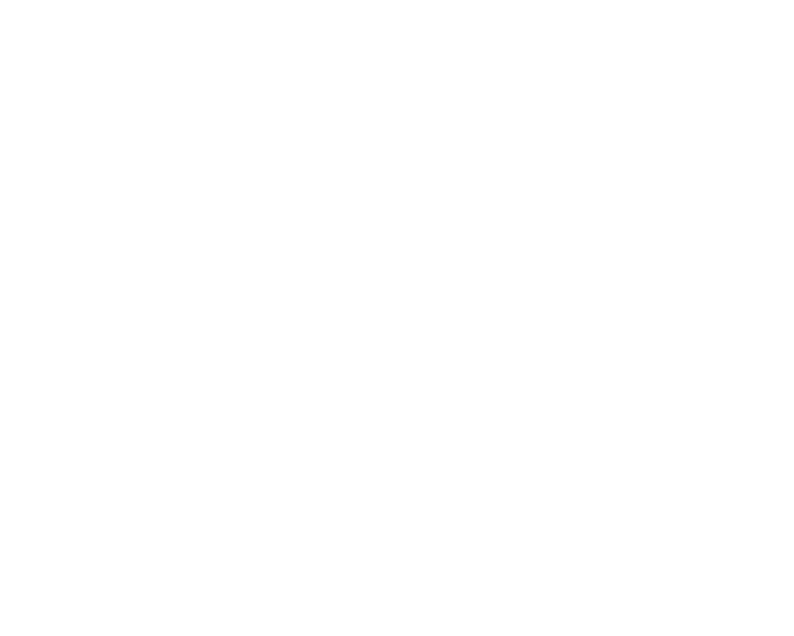

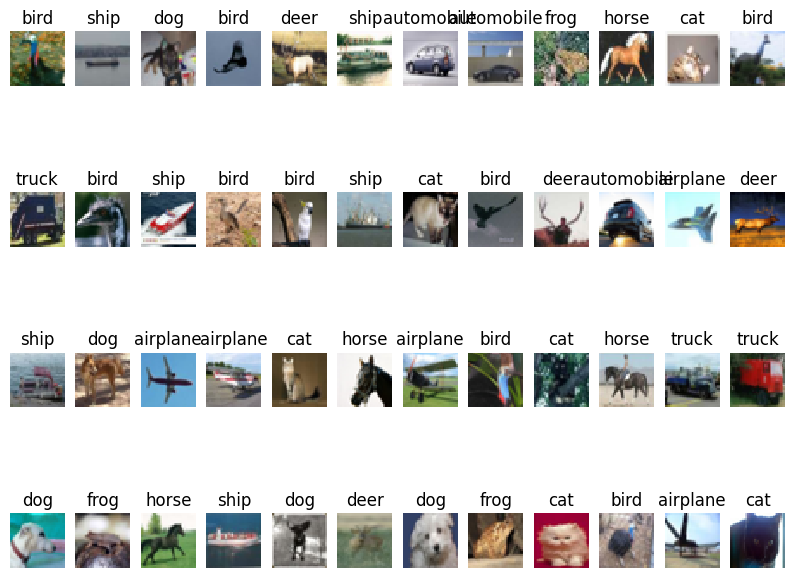

In [3]:
Data_train, y_train, Data_val, y_val, Data_test, y_test, Data_dev, y_dev, Data_batch, y_batch, label_names = get_CIFAR10_data()
X_train, X_val, X_test, X_dev, X_batch, = (preprocess_CIFAR10_data(Data) for Data in (Data_train, Data_val, Data_test, Data_dev, Data_batch))

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)
print('batch data shape: ', X_batch.shape)
print('batch labels shape: ', y_batch.shape)
  
print("CIFAR10 est un jeu de données d'images RGB 32x32x3 séparées en 10 classes")
print(label_names)

display_images(Data_train, y_train, label_names)

## Classifieur linéaire avec fonction de perte de type "Hinge loss"

Le code pour cette section est dans le fichier **utils/loss.py**. 

La fonction `hinge_naive_forward_backward` estime la perte (et le gradient) à l'aide de boucles `for` qui itèrent sur chaque donnée de la mini-batch.  

**NOTE IMPORTANTE**: les solutions que vous devez obtenir proviennent d'une implantation de type **one-vs-one** de la fonction *Hinge*.  Si nous aviez à coder une solution **one-vs-all** (également appelée *one-vs-rest*) vous devriez obtenir une loss de 8.63 (au lieu de 1.28) pour la cellule suivante et 9.09 (au lieu de 1.53) pour la cellule d'après.


In [4]:
##############################################################################
# TODO: Implémenter le calcul de perte de façon naive avec des boucles dans  #
#  la fonction hinge_naive_forward_backward située dans le fichier           #
#  utils.loss.                                                               #
#  On commence par UNE image et UNE cible                                    #
##############################################################################

from utils.loss import hinge_naive_forward_backward

# Matrice de poids aléatoires + 1 donnée à tester
np.random.seed(0)
W = np.random.randn(3073, 10) * 5e-4
X_rnd = np.random.randn(1, 3073) * 5
y_rnd = np.uint32(np.ones(1))
loss, dW = hinge_naive_forward_backward(X_rnd, W, y_rnd, 0.0)

# La loss suivante est celle que vous devriez obtenir
target_loss = 1.28220758164
loss_error = np.abs(loss - target_loss)
if loss_error < 1e-6:
    print("Bravo!")
else:
    print("Il y a un bug...")
print('loss error: %f' % loss_error)

Bravo!
loss error: 0.000000


In [5]:
##############################################################################
# TODO: Même chose qu'à la cellule précédente mais...                        #
#   vec N=500 images et autant de cibles                                     #
##############################################################################

# Matrice de poids aléatoires + 500 données 
np.random.seed(0)
W = np.random.randn(3073, 10) * 1e-4
loss, _ = hinge_naive_forward_backward(X_batch, W, y_batch, 0.0)

target_loss = 1.53644079
loss_error = np.abs(loss - target_loss)
if loss_error < 1e-6:
    print("Bravo!")
else:
    print("Il y a un bug...")
print('loss error: %f' % loss_error)


Bravo!
loss error: 0.000000


## Question 1:
   
Expliquez pourquoi lorsque la matrice de poids W est initialisée avec des valeurs proches de zéro, la **hinge loss** tend vers 1.0.

## Réponse :

Cela vient du  "1" dans $max(0, 1+ W_j^T \vec x_n - W_{t_n}^T \vec x_n )$. Les $W_t$ sont près de 0, alors on obtient max(0, 1+ ~0) $\rightarrow$ 1.

## Rétro-propagation

Maintenant, passons à la **rétro-propagation**!

In [6]:
###############################################################################
# TODO: Implémenter le calcul de perte **ET DE LA RÉTROPROPAGATION** de façon #
#       naive avec des boucles dans la fonction                               #
#       hinge_naive_forward_backward située dans le fichier utils/loss.py     #
#                                                                             #
#  On commence par UNE image et UNE cible                                     #
###############################################################################

# Matrice de poids aléatoires + une donnée
np.random.seed(0)
W = np.random.randn(3073, 10) * 1e-4
X_rnd = np.random.randn(1, 3073)
y_rnd = np.uint32(np.ones(1))
loss, dW = hinge_naive_forward_backward(X_rnd, W, y_rnd, 0.0)

# La loss suivante est celle que vous devriez obtenir
target_loss = 1.011288303265
loss_error = np.abs(loss - target_loss)
if loss_error < 1e-5:
    print("Bravo pour la loss!")
else:
    print("Il y a un bug au niveau de la loss...")
print('loss error: %f' % loss_error)

# Le gradient suivant est celui que vous devriez obtenir pour les 3 premiers poids
target_dW = np.array([0.0, 1.28672636, 0.0])
dW_error = np.mean(np.abs(dW[0,0:3]-target_dW))
if dW_error < 1e-7:
    print("Bravo pour le gradient!")
else:
    print("Il y a un bug au niveau du gradient...")
print('gradient error %f' % dW_error)

Bravo pour la loss!
loss error: 0.000000
Bravo pour le gradient!
gradient error 0.000000


In [7]:
##############################################################################
# TODO:                                                                      #
#  Maintenant on test avec N=200 images et autant de cibles                  #
##############################################################################

# Matrice de poids aléatoires + 500 données
np.random.seed(1)
W = np.random.randn(3073, 10) * 1e-4
loss, dW = hinge_naive_forward_backward(X_batch, W, y_batch, 0.0)

# La loss suivante est celle que vous devriez obtenir
target_loss = 1.5373299967
loss_error = np.abs(loss - target_loss)
if loss_error < 1e-5:
    print("Bravo pour la loss!")
else:
    print("Il y a un bug au niveau de la loss...")
print('loss error: %f' % loss_error)

# Le gradient suivant est celui que vous devriez obtenir pour les 3 premiers poids
target_dW = np.array([-2.395425, -0.840625, -0.32925, 7.256375])
dW_error = np.mean(np.abs(dW[0,0:4]-target_dW))
if dW_error < 1e-7:
    print("Bravo pour le gradient!")
else:
    print("Il y a un bug au niveau du gradient...")
print('gradient error %f' % dW_error)

Bravo pour la loss!
loss error: 0.000000
Bravo pour le gradient!
gradient error 0.000000


### Encore quelques vérifications d'usage
En principe, à ce point-ci, le calcul de la hinge loss (et de son gradient) via la fonction *hinge_naive_forward_backward* devrait fonctionner.  Mais avant de passer à la prochaine étape il nous reste deux vérifications à faire : s'assurer que la **régularisation** fonctionne et passer le test du **gradient numérique**

In [9]:
##############################################################################
# En principe, le fait d'augmenter le terme de régularisation L2 devrait     #
# augmenter la loss...                                                       #
##############################################################################
success = True

# Matrice de poids aléatoires + 500 données
np.random.seed(1)
W = np.random.randn(3073, 10) * 1e-4
prev_loss, _ = hinge_naive_forward_backward(X_dev, W, y_dev, 0.0)

reg = 1e2
for i in range(10):
    loss, _ = hinge_naive_forward_backward(X_dev, W, y_dev, reg)
    print(loss)
    if loss <= prev_loss:
        success = False
    prev_loss = loss
    reg *= 1.5
    
if success:
    print("Bravo!")
else:
    print('Erreur!')


1.5783114131770606
1.5859814253073452
1.597486443502772
1.6147439707959124
1.640630261735623
1.6794596981451888
1.7377038527595376
1.8250700846810608
1.9561194325633455
2.152693454386773
Bravo!


In [10]:
##############################################################################
# Maintenant testons le gradient numérique avec et sans régularisation       #
# Les erreurs relatives devraient être inférieures à 1e-6                    #
##############################################################################
from utils.gradients import check_gradient_sparse

print("\n------------\nGradient check : reg=0\n------------\n")
check_gradient_sparse(hinge_naive_forward_backward, W, X_dev, y_dev, 0.0)

# Faire un autre test de gradients avec régularisation 
print("\n------------\nGradient check : reg=1e-2\n------------\n")
check_gradient_sparse(hinge_naive_forward_backward, W, X_dev, y_dev, 1e2)


------------
Gradient check : reg=0
------------

numerical: -0.762608, analytic -0.762608, relative error: 5.390043e-11
numerical: 0.557516, analytic 0.557516, relative error: 7.031214e-11
numerical: -2.997860, analytic -2.997860, relative error: 2.189019e-11
numerical: -0.809764, analytic -0.809764, relative error: 1.839891e-10
numerical: -1.102012, analytic -1.102012, relative error: 1.065696e-10
numerical: -7.539276, analytic -7.539276, relative error: 3.779951e-12
numerical: 0.964800, analytic 0.964800, relative error: 1.135832e-10
numerical: -5.113284, analytic -5.113284, relative error: 4.428269e-11
numerical: -1.512672, analytic -1.512672, relative error: 2.479644e-12
numerical: -0.408000, analytic -0.408000, relative error: 8.935595e-12

------------
Gradient check : reg=1e-2
------------

numerical: -0.785541, analytic -0.785541, relative error: 3.085895e-10
numerical: 3.113448, analytic 3.113448, relative error: 2.692551e-11
numerical: 4.831795, analytic 4.831795, relative 

## Hinge loss et gradients vectorisés
Passons maintenant aux choses sérieuses. Vous devez ici coder la version vectorisée de l'entropie croisée et du gradient dans la fonction **hinge_naive_forward_backward**.  Ce code s'apparente à la réponse que vous avec donné au début.

### Question 2:  
Les prochaines étapes consistent à implanter le calcul de la loss et du gradient de la loss de façon **linéarisée**.  Avant de commencer à coder, veuillez donner ici la formule de la loss et du gradient pour une mini-batch de 500 données contenue dans le tableau 

$$X \in R^{500\times 3073}$$

et une matrice de poids $$W \in R^{3073\times 10}$$ 

où 3073 est la dimensionnalité des données et 10 est le nombre de classes.

**Votre Réponse:** 

$$Loss = \frac{1}{500} \sum^{500} _{n = 1}max(0, 1 + W_{j} ^T \vec x_n -   W_{t_{n}} ^{T} \vec x_n )  + 0.5* \lambda||W||^2$$

avec $W_{j} ^T \vec x_n $ le score de la classe predite

$$dW = [dW_{1},dW_{2,...,dW_{10}}] + reg\times W$$ 
$$dW_{j} = \frac{1}{500} \times \sum _n \nabla _{W_j} E(x_n)$$ 
avec $\nabla_{W_j} E(x_n) = \left\{ 
  \begin{aligned}
     & \vec x_n \ si \  j \ne t_n \ et \   W_{t_{n}} ^{T} \vec x_n < W_{j} ^T \vec x_n + 1  \\
     & - \vec x_n \ si \  j = t_n \ et \   W_{t_{n}} ^{T} \vec x_n < W_{j} ^T \vec x_n + 1  \\ 
     &  0  \ sinon\\
  \end{aligned}
  \right.$

**NOTE IMPORTANT** : la réponse à cette question doit contenir un nombre minimal de boucles car vous devez privilégier des multiplications matricielles et ventorielles.  De plus, considérant que la solution ne contient pas plus de 15 lignes de code Python, il est inutile de complexifiée la réponse.  En d'autres mots, on attend une réponse de quelques lignes (et non quelques pages!). 

In [8]:
##############################################################################
# TODO: Implémenter le calcul de perte et du gradient de façon vectorielle   #
# dans la fonction hinge_naive_forward_backward située dans le fichier        #
# utils.loss.                                                                #
# Les deux versions devraient calculer les mêmes résultats, mais la version  #
# vectorielle devrait être BEAUCOUP PLUS RAPIDE.                             #
##############################################################################
start = time.time()
loss_naive, grad_naive = hinge_naive_forward_backward(X_dev, W, y_dev, 0.00001)
end = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, end - start))

from utils.loss import hinge_forward_backward
start = time.time()
loss_vectorized, grad_vectorized = hinge_forward_backward(X_dev, W, y_dev, 0.00001)
end = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, end - start))

grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
loss_diff = np.abs(loss_naive - loss_vectorized)
if loss_diff < 1e-7:
    print('bravo pour la loss!')
else:
    print('il y a un bug au niveau de la loss')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))

if grad_difference < 1e-7:
    print('bravo pouµr le gradient !')
else:
    print('il y a un bug au niveau du gradient')
print('Gradient difference: %f' % grad_difference)

naive loss: 1.575795e+00 computed in 4.857464s
vectorized loss: 1.575795e+00 computed in 0.003001s
bravo pour la loss!
Loss difference: 0.000000
bravo pouµr le gradient !
Gradient difference: 0.000000


## Entraînement
À l'aide de la classe **LinearClassifier** (dans *model/LinearClassifier.py*) ainsi que de la fonction vectorisée **hinge_forward_backward** que vous venez de coder, vous devez maintenant entraîner un réseau de neurones multiclasses linéaire à l'aide d'une **descente de gradient**.

Iterations : 5000 / 5000

train vs val acc 0.255755 / 0.251000


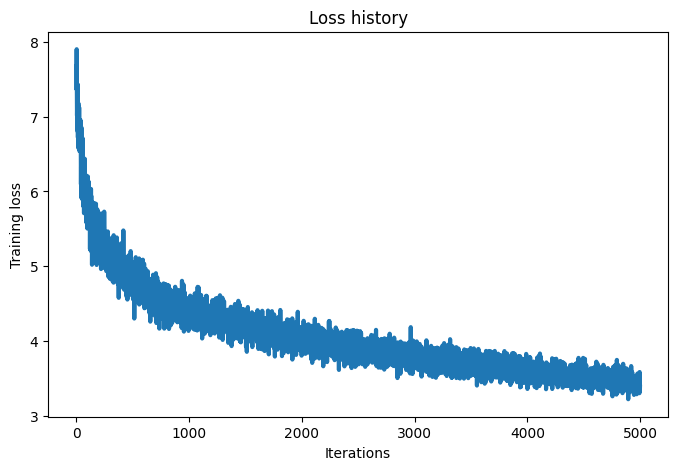

In [9]:
from model.LinearClassifier import LinearClassifier
from visualization.utils import visualize_loss
import itertools as it
lr = 1e-7
reg = 100

classifier = LinearClassifier(hinge_forward_backward)
#
# TODO : ajouter code à la fonction train.  Si tout fonctionne bien, la courbe de la loss devrait décroitre
#
train_loss_history = classifier.train(X_train, y_train, learning_rate=lr, reg=reg, num_iter=5000, verbose = True)

y_train_pred = classifier.predict(X_train)
y_val_pred = classifier.predict(X_val)

acc_train = np.mean(y_train == y_train_pred)
acc_val = np.mean(y_val == y_val_pred)

print('train vs val acc %f / %f' %(acc_train, acc_val))

visualize_loss(train_loss_history)

## Recherche d'hyper-paramètres

best validation accuracy achieved during cross-validation: 0.296000


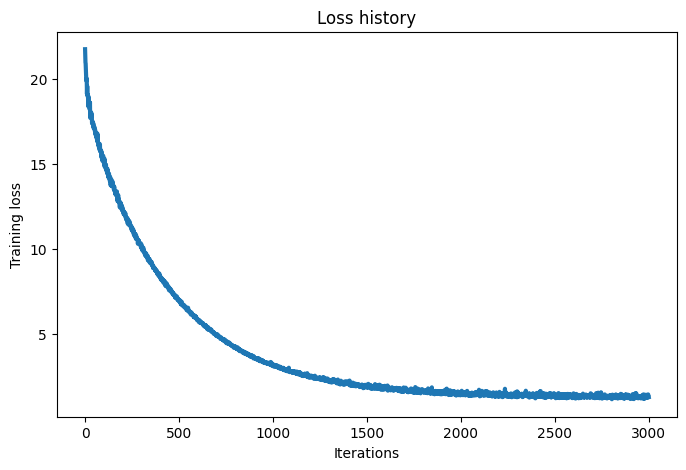

In [10]:
from model.LinearClassifier import LinearClassifier
from visualization.utils import visualize_loss
import itertools as it
results = {}
best_val = -1
best_reg = -1
best_lr = -1
learning_rates = np.linspace(1e-8, 1e-6, 5)
regularization_strengths = np.linspace(1, 1e3, 3)
best_loss_history = None
best_classifier = None

##############################################################################
# TODO: Utilisez l'ensemble de validation pour régler les hyper-paramètres   #
#  (regularization_strength et learning_rate). Vous devez                    #
#  expérimenter différentes plages de valeurs pour ces deux hyper-paramètres.#
#  Si tout va bien, avec num_iter = 3000  vous devriez obtenir une           #
#  précision de classification d'environ à 0.30 sur l'ensemble de validation #
#  et sur l'ensemble de test.                                                #
#  Mettre les résultats des meilleurs hyper-paramètres dans les variables    #
#  best_XYZ ci haut.                                                         #
##############################################################################

for lr in learning_rates:
    for reg in regularization_strengths:
        cls = LinearClassifier(hinge_forward_backward)
        loss = cls.train(X_train, y_train, learning_rate=lr, reg=reg, num_iter=3000)
        YPred = cls.predict(X_val)
        accVal = np.mean(y_val == YPred)
        results[accVal] = cls, lr, reg, loss

best_val = max(results.keys())
best_classifier, best_lr, best_reg, best_loss_history = results[best_val]

################################################################################
#                             FIN DE VOTRE CODE                                #
################################################################################
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

visualize_loss(best_loss_history)

In [11]:
# En réentraine avec plus d'itérations
train_loss_history = best_classifier.train(X_train, y_train, learning_rate=best_lr, reg=best_reg, num_iter=6000, verbose = True)

# On évalue la performance sur l'ensemble de test
y_test_pred = best_classifier.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('Linear model with Hinge loss : CIFAR-10 final test accuracy: %f' % (test_accuracy) )

Iterations : 6000 / 6000

Linear model with Hinge loss : CIFAR-10 final test accuracy: 0.204000


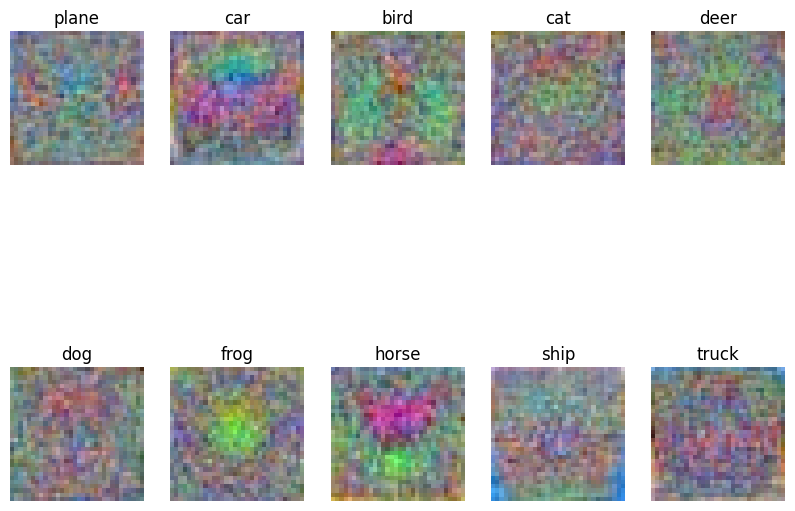

In [12]:
# Visualisation des poids appris pour chaque classe
w = best_classifier.W[:-1,:] # retire le biais
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Redimensionne les poids pour qu'ils soient entre 0 et 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])